# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from math import ceil

In [2]:
leads = pd.read_csv('leads_cleaned_2.csv', index_col=0)

In [3]:
print(leads.dtypes)
leads.head()

lead_number          int64
origin              object
source              object
no_email             int64
converted            int64
visits             float64
visit_time           int64
visit_pages        float64
last_activity       object
country             object
specialization      object
hear_about          object
occupation          object
search               int64
recommendations      int64
quality             object
profile             object
city                object
activity_index       int64
profile_index        int64
mti_copy             int64
modified             int64
dtype: object


,lead_number,origin,source,no_email,converted,visits,visit_time,visit_pages,last_activity,country,...,occupation,search,recommendations,quality,profile,city,activity_index,profile_index,mti_copy,modified
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Unknown,...,Unemployed,0,0,Low in Relevance,Unknown,Unknown,2,2,0,1
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,India,...,Unemployed,0,0,Unknown,Unknown,Unknown,2,2,0,0
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,India,...,Student,0,0,Might be,Potential Lead,Mumbai,2,3,1,0
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,India,...,Unemployed,0,0,Not Sure,Unknown,Mumbai,2,2,0,1
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,India,...,Unemployed,0,0,Might be,Unknown,Mumbai,2,3,0,1


### Encoding Categorical Variables
Our dataset includes 10 categorical variables that still need to be encoded. These are all nominal categories (our two ordinal categories have already been encoded), and can be handled with One Hot Encoding. However, some of these categories (such as country and source) have rather high cardinality, so it may be useful later to see if combining some of the low-count values improves our model.

In [4]:
# Checking the cardinality of categorical variables. For now, we will leave them as-is.
leads.select_dtypes(include=['object']).nunique()

origin             5
source            21
last_activity     18
country           39
specialization    19
hear_about        10
occupation         7
quality            6
profile            6
city               7
dtype: int64

In [5]:
leads = pd.get_dummies(leads)
leads.shape

(9240, 150)

In [6]:
# We can delete the 'Unknown' columns, as a 0 in all other columns already contains that information.
for col in leads.columns:
    if 'Unknown' in col:
        leads.drop(col, axis=1, inplace=True)

leads.shape

(9240, 141)

In [7]:
# To begin modeling, we'll separate our dependent variable y, and remove the lead_number column (we don't want this id
# column to influence our model, since any possible correlation with this dataset won't help us with future predictions).
y = leads.converted
X = leads.drop(['converted', 'lead_number'], axis=1)

# PCA
Before we begin, we can check whether our data can be simplified through dimension reduction. If we can reduce the dimensionality of our data, it could make distance-based models more effective.

In [8]:
# First we must scale the data to standardize variance of each feature.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<AxesSubplot:xlabel='1', ylabel='2'>

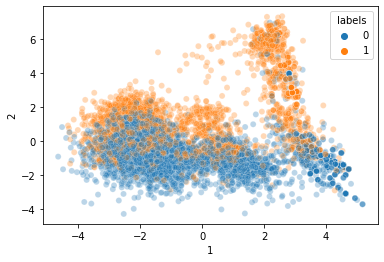

In [9]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[str(n+1) for n in range(139)])
pca_df['labels'] = y

sns.scatterplot(data=pca_df, x='1', y='2', hue='labels', alpha=0.3)

It looks like there is some significance to the second principal component (on the y axis) in relation to the dependent variable

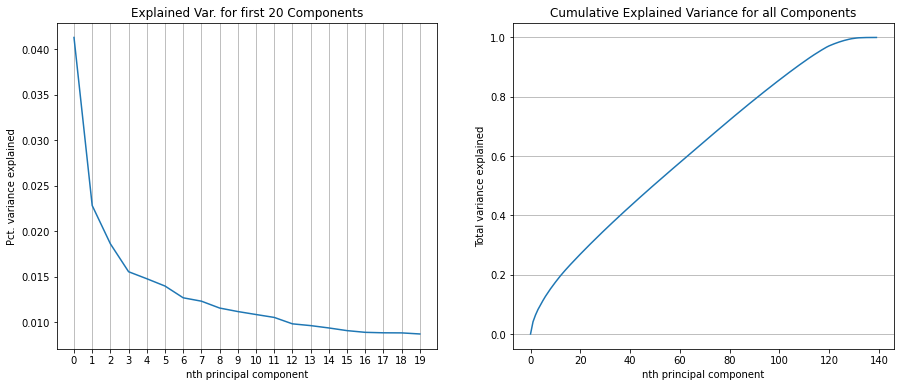

In [10]:
# Let's look at the first 20 components and plot the explained variance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(20), pca.explained_variance_ratio_[:20])
plt.title('Explained Var. for first 20 Components')
plt.xlabel('nth principal component')
plt.ylabel('Pct. variance explained')
plt.xticks(range(0, 20, 1))
plt.grid(axis='x')

# And now to see the cumulative explained variance over all components
ev_cumulative = [0]
for i, ev in enumerate(pca.explained_variance_ratio_):
    ev_cumulative.append(ev_cumulative[i] + ev)

plt.subplot(1, 2, 2)
plt.plot(range(len(ev_cumulative)), ev_cumulative)
plt.title('Cumulative Explained Variance for all Components')
plt.xlabel('nth principal component')
plt.ylabel('Total variance explained')
plt.grid(axis='y')
plt.show()

Judging from these graphs, although the gain in variance explained does level off after the fourth component, those components still only account for less than 15% of the variance. In order not to lose too much information from the data, we shouldn't reduce the dimensionality that much.

Furthermore, by not using PCA to reduce the dimensions of our data, we are able to maintain a strong interpretability of our results. This will help towards one of the main goals of this project, which is to identify specific features that the marketing team can target in order to achieve greater quality of leads overall.

# Logistic Regression

The goal of this project is to be able to assign a score of likelihood of conversion for each new lead, based on the information collected. To do this, we will try a few different models to see which gives us the best predictive capabilities.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
lr_model = LogisticRegression(solver='liblinear', max_iter=200)
lr_pipeline = make_pipeline(scaler, lr_model)

In [13]:
# Find the best value for the regularization parameter C, optimizing roc_auc
c_dict = {'logisticregression__C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv_model = GridSearchCV(lr_pipeline, c_dict, scoring='roc_auc')
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'logisticregression__C': 0.01}

In [14]:
# Redefine the pipeline with the best C=0.01
scaler = StandardScaler()
lr_model = LogisticRegression(solver='liblinear', C=0.01)
lr_pipeline = make_pipeline(scaler, lr_model)

In [15]:
lr_pipeline.fit(X_train, y_train)
preds = lr_pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1107
           1       0.84      0.79      0.81       741

    accuracy                           0.85      1848
   macro avg       0.85      0.84      0.85      1848
weighted avg       0.85      0.85      0.85      1848



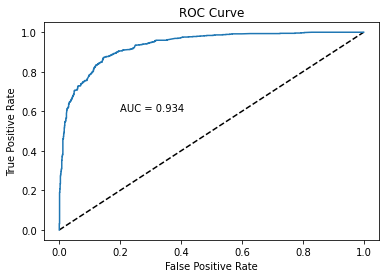

In [16]:
pred_prob = lr_pipeline.predict_proba(X_test)[:,1]
auc = round(roc_auc_score(y_test, pred_prob),3)
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.annotate('AUC = '+str(auc), (0.2,0.6))
plt.show()

Here we see a nice ROC curve, showing that the Logistic Regression model achieves close to perfect True Positive rate with a reasonably low False Positive rate.

Practically, we would rather spend time on a lead that does not convert than ignore a lead that could possibly convert. So, we should be willing to accept some False Positives if it means we won't miss any possible conversions. In other words, we want our model to have a high recall for positive cases. In the above classification report, we see our model had a recall for the positive case of about 80%. This is a decent score, though we should definitely look at other models to see if they can do better.

But first, we should look at what kind of lead scores we would see using this model. When we compute scores for new leads, we will not actually need to assign a label. Instead, we will use the predicted probability of conversion as a score from 1-10 to indicate the strength of each lead (essentially, binning each new lead into a group with a particular likelihood of conversion).

Although our model will of course have some erroneous predictions for individual leads, it is more important for our purposes to check whether the predicted probabilities will match actual conversion rates for new leads.

In [17]:
# Converting predicted probabilities to scores.
probs = lr_pipeline.predict_proba(X_test)[:,1]
test_scores = pd.DataFrame({'converted':y_test, 'predicted':preds, 'probability':probs}, index=y_test.index)
scores = [ceil(p * 10) for p in probs]
test_scores['lead_score'] = scores
test_scores.head(10)

,converted,predicted,probability,lead_score
4608,1,0,0.177138,2
7935,0,0,0.050245,1
4043,0,0,0.021582,1
7821,0,0,0.216316,3
856,0,0,0.089381,1
927,0,0,0.213813,3
318,1,1,0.970389,10
1018,0,0,0.073293,1
8151,0,0,0.256033,3
1570,1,1,0.970359,10


In [18]:
for score in set(scores):
    group = test_scores[test_scores.lead_score==score]
    group_size = len(group)
    conversion_rate = group.converted.sum()/group_size
    print("Lead Score {}: {}% (of {}) conversion in test set".format(score, round(conversion_rate*100,1), group_size))

Lead Score 1: 1.8% (of 547) conversion in test set
Lead Score 2: 11.2% (of 277) conversion in test set
Lead Score 3: 23.5% (of 153) conversion in test set
Lead Score 4: 38.1% (of 97) conversion in test set
Lead Score 5: 56.8% (of 74) conversion in test set
Lead Score 6: 50.0% (of 94) conversion in test set
Lead Score 7: 67.6% (of 74) conversion in test set
Lead Score 8: 77.8% (of 90) conversion in test set
Lead Score 9: 92.0% (of 138) conversion in test set
Lead Score 10: 95.7% (of 304) conversion in test set


Roughly, we want the numerical lead score to correspond to the probability of conversion (that is, a score of 5 means 50% chance of success). The actual conversion rates above show that the score is less reliable for the lower scores. This might be acceptible, since we would tend to deprioritize low-scoring leads either way.

In this sample, the 5s actually converted more often than 6s. This could, of course, be due to the limited sample of the test data, since these groups have relatively few examples represented. Still, we should expect to see a higher rate among the 6s.

Finally, before moving on, let's look at the coefficients of the Logistic Regression model to see which features were most important.

In [19]:
coefs = lr_pipeline['logisticregression'].coef_[0]
coef_df = pd.DataFrame({'feature':X.columns, 'coef_dir':coefs>=0, 'coef_abs':abs(coefs)})
coef_df.sort_values('coef_abs', ascending=False).head(20)

,feature,coef_dir,coef_abs
2,visit_time,True,0.870285
123,quality_High in Relevance,True,0.616709
47,last_activity_SMS Sent,True,0.472091
122,occupation_Working Professional,True,0.469252
125,quality_Might be,True,0.438111
124,quality_Low in Relevance,True,0.409947
127,quality_Worst,False,0.362053
29,source_Welingak Website,True,0.328339
44,last_activity_Olark Chat Conversation,False,0.305329
9,modified,False,0.300476


We see the most important feature by far is visit_time, followed by leads marked as high-quality.

The 'quality' field appears several times in these top features, which makes sense. Recall that quality was defined as "the quality of lead based on the data and intuition the the employee who has been assigned to the lead." This column, then, is itself a subjective lead score given by sales staff.

The information from this column is clearly important to our model, and we don't want to lose it. However, it should be noted that this may be a problem if we want to use our model for assigning leads - we won't have this information until after the lead is assigned! Instead, I suggest either (a) Have staff quickly give a first impression of quality for all new leads before scoring and assigning the lead, or (b) distribute leads randomly, then score and redistribute leads once this category can be filled.

# Random Forest
Next, we'll try a Random Forest model and see if we can improve our scoring system.

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf_scaler = StandardScaler()
rf_model = RandomForestClassifier(random_state=0)
rf_pipeline = make_pipeline(rf_scaler, rf_model)

In [64]:
# Find the best value for 25
param_dict = {'randomforestclassifier__n_estimators':[100, 200],
             'randomforestclassifier__max_depth':[5, 10, 15, 20],
             'randomforestclassifier__max_features':['auto', 10, 20]
             }
cv_model = GridSearchCV(rf_pipeline, param_dict, scoring='roc_auc')
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 200}

In [70]:
rf_model = RandomForestClassifier(random_state=0, max_depth=15, n_estimators=200)
rf_pipeline = make_pipeline(rf_scaler, rf_model)
rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [72]:
preds = rf_pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1107
           1       0.87      0.77      0.82       741

    accuracy                           0.86      1848
   macro avg       0.86      0.85      0.85      1848
weighted avg       0.86      0.86      0.86      1848



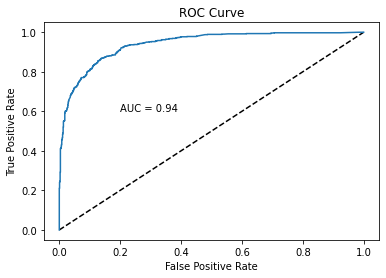

In [75]:
probs = rf_pipeline.predict_proba(X_test)[:,1]
auc = round(roc_auc_score(y_test, probs),3)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.annotate('AUC = '+str(auc), (0.2,0.6))
plt.show()

In [77]:
# Converting predicted probabilities to scores.
test_scores = pd.DataFrame({'converted':y_test, 'predicted':preds, 'probability':probs}, index=y_test.index)
scores = [ceil(p * 10) for p in probs]
test_scores['lead_score'] = scores

for score in set(scores):
    group = test_scores[test_scores.lead_score==score]
    group_size = len(group)
    conversion_rate = group.converted.sum()/group_size
    print("Lead Score {}: {}% (of {}) conversion in test set".format(score, round(conversion_rate*100,1), group_size))

Lead Score 1: 1.3% (of 464) conversion in test set
Lead Score 2: 8.1% (of 307) conversion in test set
Lead Score 3: 15.5% (of 155) conversion in test set
Lead Score 4: 37.7% (of 154) conversion in test set
Lead Score 5: 52.3% (of 109) conversion in test set
Lead Score 6: 57.1% (of 84) conversion in test set
Lead Score 7: 73.6% (of 121) conversion in test set
Lead Score 8: 91.1% (of 124) conversion in test set
Lead Score 9: 95.6% (of 136) conversion in test set
Lead Score 10: 98.5% (of 194) conversion in test set


The f1 scores for this Random Forest model is slightly higher than the Logistic Regression scores. However, our target of recall for positive cases is slightly lower.

Looking at the actual conversion rates for each lead score group, again the low scoring leads have lower than expected conversion. The conversion rate for 8s is higher than expected using this model. Also, compared with the Logistic Regression model, this model esparates the groups into more even sizes.